In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

Key properties of Cauchy class:
- $α ∈ (0, 2]$ controls smoothness: smaller $α$ → rougher paths
- $β > 0$ controls decay rate: smaller $β$ → slower decay, longer memory
- $β ∈ (0,1)$ gives long memory processes, with Hurst coefficient $H = 1 - β/2$
- Fractal dimension $D = n + 1 - α/2$ (for n-dimensional space)
- Allows arbitrary combinations of fractal dimension and Hurst coefficient

In [ ]:
def cauchy_correlation(h, alpha, beta):
    if alpha <= 0 or alpha > 2:
        raise ValueError("alpha ∈ (0, 2]")
    if beta < 0:
        raise ValueError("beta > 0")
    
    return (1 + np.abs(h)**alpha)**(-beta/alpha)

In [ ]:
def cauchy_covariance(t, alpha, beta, sigma2=1.0):
    """
    Build covariance matrix for Cauchy class process.
    
    Parameters:
    t : int, number of time points
    alpha : float, in (0, 2], controls smoothness
    beta : float, > 0, controls decay rate
    sigma2 : float, marginal variance
    """
    K = torch.zeros((t, t))
    
    for i in range(t):
        for j in range(t):
            if i <= j:
                h = i - j
                K[i, j] = K[j,i] = sigma2 * cauchy_correlation(h, alpha, beta)
    
    # Add small diagonal term for numerical stability
    K += 1e-8 * torch.eye(t)
    
    return K

In [4]:
def sample_cauchy_process(t, alpha, beta, sigma2=1.0, offset=0.0, n_samples=1):
    """
    Sample from Cauchy class Gaussian process.
    
    Parameters:
    t : int, number of time points
    alpha : float, smoothness parameter in (0, 2]
    beta : float, decay parameter > 0
    sigma2 : float, marginal variance
    n_samples : int, number of sample paths
    """
    vcov = cauchy_covariance(t, alpha, beta, sigma2)
    
    mvn = torch.distributions.MultivariateNormal(
        loc=torch.full((t,), offset, dtype = vcov.dtype),
        covariance_matrix=vcov
    )
    return mvn.rsample((n_samples,))

In [5]:
def hurst_coef(beta):
    if beta < 1:
        return 1 - beta/2
    else:
        return None

In [6]:
cauchy_covariance(50, 0.5, 100)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

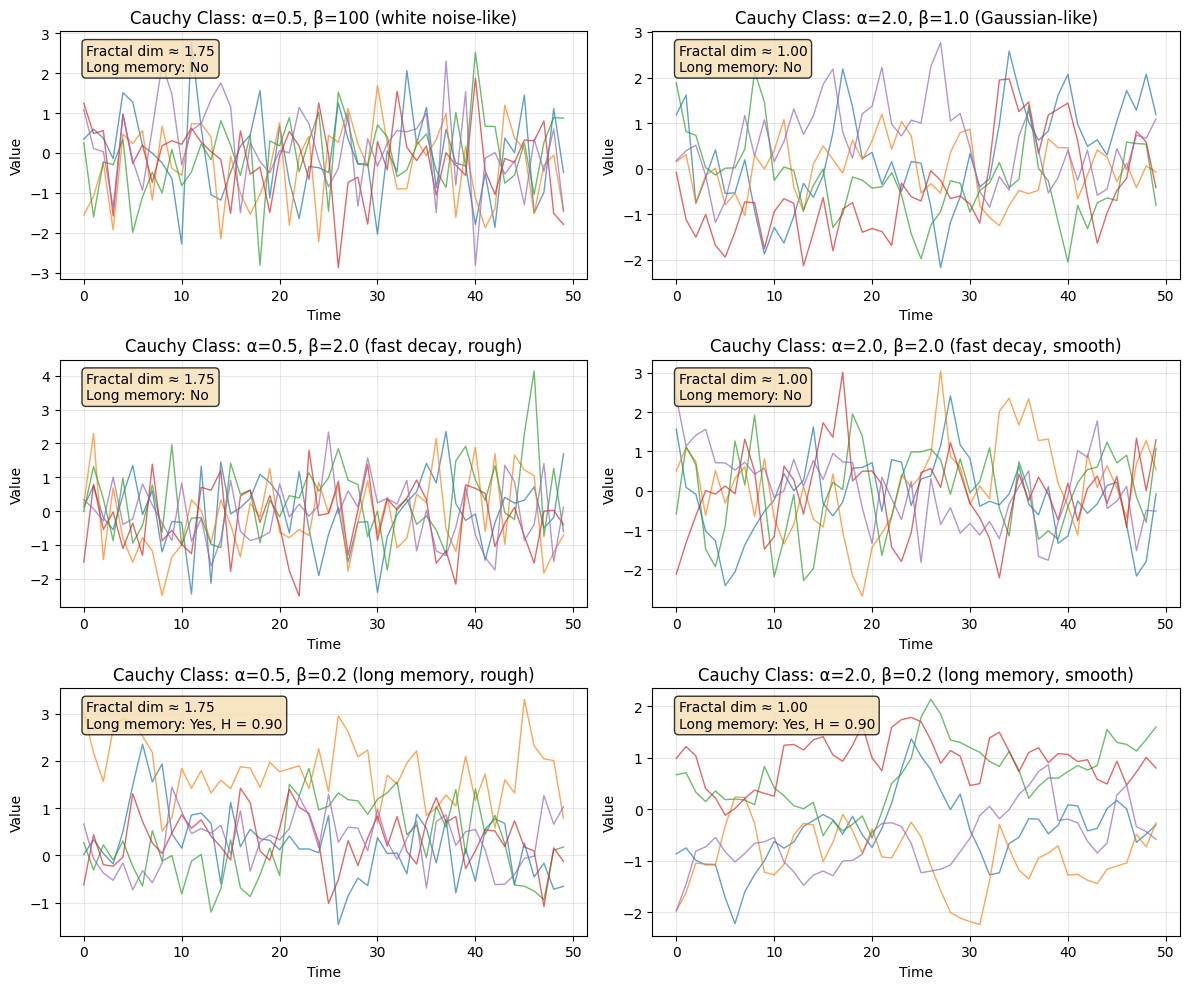

In [9]:
# Time points
T = 50
t = np.arange(0, T)

# Different parameter combinations
params = [
    (0.5, 100.0, "α=0.5, β=100 (white noise-like)"),
    (2.0, 1.0, "α=2.0, β=1.0 (Gaussian-like)"),
    (0.5, 2.0, "α=0.5, β=2.0 (fast decay, rough)"),
    (2.0, 2.0, "α=2.0, β=2.0 (fast decay, smooth)"),
    (0.5, 0.2, "α=0.5, β=0.2 (long memory, rough)"),
    (2.0, 0.2, "α=2.0, β=0.2 (long memory, smooth)")
]

# Generate samples
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (alpha, beta, label) in enumerate(params):
    samples = sample_cauchy_process(T, alpha, beta, sigma2=1.0, 
                                    n_samples=5)
    
    axes[i].plot(t, samples.T, alpha=0.7, linewidth=1)
    axes[i].set_title(f'Cauchy Class: {label}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')
    axes[i].grid(True, alpha=0.3)
    
    # Add fractal dimension info
    D = 1 + 1 - alpha/2  # For 1D case (n=0 in D = n + 1 - α/2)
    H = hurst_coef(beta)
    long_memory = f"Yes, H = {H:.2f}" if beta < 1 else "No"
    axes[i].text(0.05, 0.95, f'Fractal dim ≈ {D:.2f}\nLong memory: {long_memory}', 
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

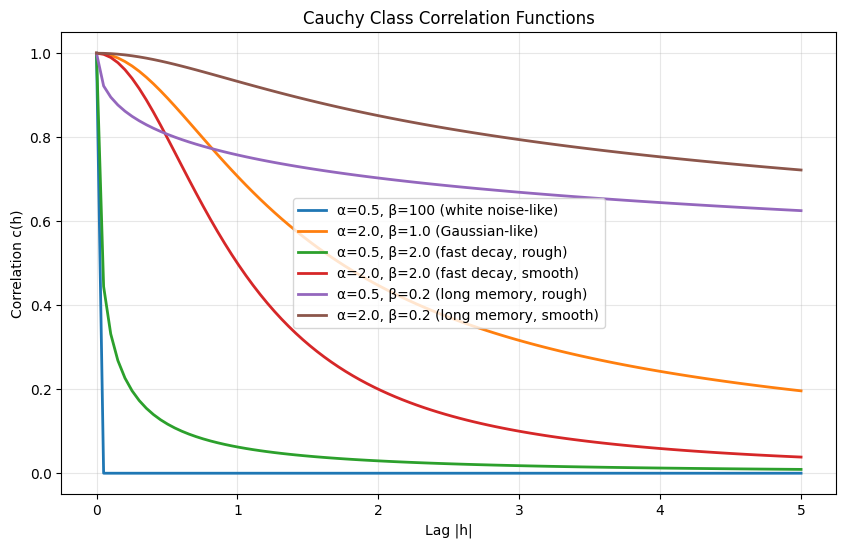

In [ ]:
# Show correlation function behavior
h_values = np.linspace(0, 5, 100)

plt.figure(figsize=(10, 6))
for alpha, beta, label in params:
    corr_vals = cauchy_correlation(h_values, alpha, beta)
    plt.plot(h_values, corr_vals, label=label, linewidth=2)

plt.xlabel('Lag |h|')
plt.ylabel('Correlation c(h)')
plt.title('Cauchy Class Correlation Functions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()